# Semantic Analysis with LLMs<div class="tocSkip">
    
&copy; Jens Albrecht, 2023
    
This notebook can be freely copied and modified.  
Attribution, however, is highly appreciated.

<hr/>

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2023-text-mining/raw/main'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "matplotlib"

# path to import blueprints packages
sys.path.append(f'{BASE_DIR}/packages')

## Load Data

First, we create a subset of the data containing 500 samples of BMW, Volkswagen, and Tesla each.

In [5]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-prepared.csv", sep=";", decimal=".")

# add a column for the text length
df['len'] = df['text'].map(lambda t: len(t.split()))

# create a subset of the data containing 500 random samples from these subreddits
subreddits = ['BMW', 'Volkswagen', 'teslamotors']

# create initial empty dataframe
sample_df = df.query("subreddit == 'xxx'")[['id', 'subreddit', 'text', 'len']]

# add 500 samples for each subreddit
for subreddit in subreddits:
    subreddit_sample_df = df.query("subreddit == @subreddit and len > 80 and len < 500")[['id', 'subreddit', 'text', 'len']].sample(500)
    sample_df = pd.concat([sample_df, subreddit_sample_df])

sample_df.reset_index(inplace=True, drop=True)

# rename teslamotors to Tesla
sample_df['subreddit'] = sample_df['subreddit'].map(lambda s: 'Tesla' if s == 'teslamotors' else s)
df['subreddit']        = df       ['subreddit'].map(lambda s: 'Tesla' if s == 'teslamotors' else s)

# save samples
# sample_df.to_json('reddit-autos-selfposts-gpt-sentiment-samples.json', orient='records')

subreddit
BMW           500
Volkswagen    500
Tesla         500
Name: count, dtype: int64

In [9]:
sample_df = pd.read_json('../data/reddit-autos-selfposts-gpt-sentiment-samples.json', orient='records')

sample_df['subreddit'].value_counts().to_frame()

,count
subreddit,
BMW,500
Volkswagen,500
Tesla,500


In [10]:
pd.set_option('display.max_colwidth', None)
sample_df.sample(5)
pd.set_option('display.max_colwidth', 200)

,id,subreddit,text,len
494,lhcr06,BMW,"Are hidden fees customary at bmw dealers?: Hi, I'm in the market for a car and have always wanted a bimmer. I'm using geicos version of truecar, and when it gives me the price, they are blown up by 1 to 5k for all kinds of things like closing fees, destination fees, dealer fees, and other stuff. Normal things like registration fees are usually broken out separately. Why would a used car dealer charge a destination fee for a car that's sitting in their lot?",85
332,lqv1nq,BMW,"My F30 is repeatedly blowing the subwoofer!: Hey folks I've been very happy with my 2017 340i 6MT MPPK so far, but I am having a repetitive issue with the sound system. Around 48 k miles, my subwoofer blew. It developed this horrible flatulent sound that is very obvious even with talk radio. Pretty much any frequency that activates the subwoofer would cause a very loud rattling noise. It's not a mechanical sound, it is definitely coming from the under-seat sub. There isn't anything rattling around. I took it to a dealer initially before I knew what it was. At that time the issue was intermittent and hard to replicate reliably, so the first dealer thought it was the door lock and they placed some damping material in there. The problem quickly came back, and a second dealer correctly diagnosed it as the subwoofer gone bad. At that point I was right around 49 k miles and they replaced the subwoofer under warranty. That fixed the issue... for a while. Here's what it sounds like: _URL_ Now it's been about 3 weeks and the problem has recurred again! The subwoofer clearly sounds blown again. It's super loud and obnoxious. It's also very apparent when accelerating both in sport and comfort modes, thanks to Active Sound, so it's bothersome even with the stereo off. The weird thing is, I almost NEVER listen to loud music. I certainly don't drive around with my car shaking from loud bass. I mostly just listen to podcasts and NPR. I have a hard time understanding how I could blow the sub again so quickly. One hypothesis I have is maybe Active Sound is somehow killing my sub? I did drive with sport mode yesterday, and noticed the problem had recurred today. With sport mode in the higher RPM's, the car does get loud, and some of the noise is from the MPPK exhaust but I think some is augmented by the stereo. I'm not out of warranty, but will bring it back to the dealer next week and see if maybe they'd be willing to fix it free of charge since the problem occurred while the warranty was active and the first repair didn't work. Otherwise, I might just have to cough up some dough to get this fixed, as it's extremely annoying Has anyone else had this problem? Anyone have any ideas what might be causing this?",403
1291,nlnhzc,Tesla,"Navigation with missing steps: Does this happen to anyone else? I'll be on a route that has for instance, highway A to highway B to highway C. When I'm on highway A, it just shows a direction to take highway C in 9 miles, completely ignoring the fact that you're supposed to take highway B in 4 miles first. The blue route path on the map shows that you're supposed to do A-B-C, but the directions completely ignore B as if it doesn't exist. I've missed highway exits before because of this, and the Nav on Autopilot missed the exit too, even though the blue route path clearly showed it was supposed to exit. Located in Arizona, model 3 LR RWD.",121
284,l6is7k,BMW,"buying first bmw (x1) - any help appreciated: looking to buy a 2019 or 2020 x1 we're planning to have a baby so time to go SUV! the plan is to buy (finance) and keep it for 10-12 years how much can we expect to pay to service properly maintain the car through to 145,000 miles (235,000 km) is this a good idea? have always just leased audi/VWs thus far and been completely headache free anything else to consider/know about? e.g. leatherette vs leather, is it a good car to have with a kid or two, resale value, build quality etc thanks in advance to anyone w

## OpenAI

In [16]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is DA53-1845

 Directory of C:\Users\Jens\Documents\Development\github\tdwi-2023-text-mining\notebooks

18.06.2023  11:51    <DIR>          .
18.06.2023  11:51    <DIR>          ..
18.06.2023  11:44                68 .env
15.06.2023  13:27    <DIR>          .ipynb_checkpoints
22.05.2023  21:05         3.804.198 Advanced.ipynb
22.05.2023  21:00         2.880.294 Classification.ipynb
28.04.2023  20:13            68.578 Data_Cleaning.ipynb
18.06.2023  11:25            15.187 Data_Extraction_Reddit.ipynb
18.06.2023  11:23            24.299 Data_Preprocessing.ipynb
18.06.2023  11:51            59.154 LLM.ipynb
16.06.2023  10:19           526.762 reddit-autos-selfposts-gpt-sentiment-temp0.2.json
15.06.2023  22:43           529.513 reddit-autos-selfposts-gpt-sentiment-temp0.8.json
22.05.2023  20:59        30.068.076 reddit-autos-selfposts-predicted.csv
19.06.2021  14:04        29.667.651 reddit-autos-selfposts-prepared.csv
04.06.2021  21:

In [25]:
import os
from dotenv import load_dotenv
load_dotenv('.env')
# os.environ['OPENAI_API_KEY'] = "<ADD YOUR API KEY HERE>"

True

In [43]:
import openai

openai.api_key = os.environ['OPENAI_API_KEY']

openai_models = openai.Model.list()
models_df = pd.DataFrame(openai_models['data'])

models_df[['id', 'root', 'parent']]

,id,root,parent
0,whisper-1,whisper-1,None
1,babbage,babbage,None
2,davinci,davinci,None
3,text-davinci-edit-001,text-davinci-edit-001,None
4,babbage-code-search-code,babbage-code-search-code,None
5,text-similarity-babbage-001,text-similarity-babbage-001,None
6,code-davinci-edit-001,code-davinci-edit-001,None
7,text-davinci-001,text-davinci-001,None
8,ada,ada,None
9,gpt-4-0613,gpt-4-0613,None


In [82]:
prompt = "Explain the term Business Intelligence with a joke in at most 100 words!"

In [47]:
response = openai.Completion.create(
  model="text-davinci-003",
  prompt=prompt,
  max_tokens=200 #, temperature=0
)

print(response['choices'][0]['text'])



Q: What did the Business Intelligence analyst say after a long day of crunching numbers?

A: “I think I need a Data Vacation!”


In [54]:
import openai

response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        #{"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
        #{"role": "assistant", "content": "..."},
        #{"role": "user", "content": "..."}
    ]
)

print(response['choices'][0]['message']['content'])

Why did the business analyst cross the road? To get to the other side of the data! Business intelligence is all about analyzing and making sense of the data to make informed decisions, just like this analyst trying to get to the other side of the road. It's a serious matter, but hey, it doesn't hurt to throw in a little humor!


## Langchain

In [84]:
from langchain.llms import OpenAI

llm = OpenAI(model_name="gpt-3.5-turbo", temperature=1) # temp between 0 (more rigid) and 2 (more flexible)
print(llm(prompt))

Why did the Business Intelligence team need a password? To keep their data warehouse a secret from the competition.


In [85]:
# more rigid model
llm = OpenAI(model_name="gpt-3.5-turbo", temperature=0.2)

In [88]:
text = """
A few weeks ago I got a 2019 BMW 440i. 
CarPlay worked flawlessly for the first month but out of no where I'm having serious problems. 
At least the panoramic sunroof works fine, and I love it.
"""

In [89]:
template = """
The following text is about a car and its components.
Identify the vendor, the car model, the components and the mentioned sentiment. 

Text: {text}
"""

In [90]:
llm = OpenAI(model_name="gpt-3.5-turbo", temperature=0.2)
prompt = template.format(text=text)
print(llm(prompt))

Vendor: BMW
Car model: 2019 BMW 440i
Components: CarPlay, panoramic sunroof
Sentiment: Negative (due to the serious problems with CarPlay) and positive (due to the love for the panoramic sunroof).


In [93]:
import json

llm = OpenAI(model_name="gpt-3.5-turbo", temperature=0.2)

template = """

Instruction: The text following the three dashes is about cars and their components. 
Extract a list in json format where each entry includes the mentioned car component or part, 
the corresponding sentiment as "positive" or "negative", 
the respective car model, the year of making and the vendor of the car, if specified.
Do not generate entries with neutral or no sentiment.
If a model name starts with a year, remove it from the model name and put it into a separate json field. 
If there is no vendor mentioned, assume it is {subreddit}.
Return only the json without further explanations. 
Each entry in the json list should have the fields "model", "vendor", "part", "sentiment", and "year".

---

Text: {text}
"""

prompt_template = PromptTemplate.from_template(template)

prompt = prompt_template.format(subreddit="BMW", text=text)
print(prompt)

print("-"*40)
print("Output: ")
print(llm(prompt))



Instruction: The text following the three dashes is about cars and their components. 
Extract a list in json format where each entry includes the mentioned car component or part, 
the corresponding sentiment as "positive" or "negative", 
the respective car model, the year of making and the vendor of the car, if specified.
Do not generate entries with neutral or no sentiment.
If a model name starts with a year, remove it from the model name and put it into a separate json field. 
If there is no vendor mentioned, assume it is BMW.
Return only the json without further explanations. 
Each entry in the json list should have the fields "model", "vendor", "part", "sentiment", and "year".

---

Text: 
A few weeks ago I got a 2019 BMW 440i. 
CarPlay worked flawlessly for the first month but out of no where I'm having serious problems. 
At least the panoramic sunroof works fine, and I love it.


----------------------------------------
Output: 
[
  {
    "model": "440i",
    "vendor": "BMW",
 

In [105]:
post_ids = ['kp6h39', 'kqapvo']

# iter_df = sample_df.sample(3)
iter_df = sample_df.query("id.isin(@post_ids)")

for index, row in tqdm(iter_df.iterrows(), total=len(iter_df)):
    # print(row['text'])
    id = row['id']
    subreddit = row['subreddit']
    text = row['text']
    prompt = prompt_template.format(subreddit=subreddit, text=text)
    output = llm(prompt, max_tokens=512)
    
    print("TEXT:")
    print(text)
    print("\nOUTPUT:")
    print(output)
    print('-'*40)

  0%|          | 0/2 [00:00<?, ?it/s]

TEXT:
2.5L Golf... vacuum pump leaking oil? Help??: I have a 2012 2.5L Golf, which I love dearly, that has a leaky vacuum pump. The dealer wants $1600 to replace the pump, but I know from doing some research that that is because they want to drop the transmission to do the repair despite the fact that it can *technically* be done without it. Seems like some people have also had luck just replacing the seals and not the whole pump. So, while I am mechanically minded enough to understand that this may be true, I'm definitely not skilled enough to do the work myself. Anyone in the New England area (I'm just outside Boston) particularly handy and willing to help a stranger out? I'm happy to come to you and pay I just think $1600 is a little excessive. Alternatively, has anyone had this work done at a shop in this area for less than $1600? ​ Help me r/volkswagen you're my only hope.

OUTPUT:
[
  {
    "model": "Golf",
    "vendor": "Volkswagen",
    "part": "vacuum pump",
    "sentiment": "

In [ ]:
import json
from json import JSONDecodeError

file = open("reddit-autos-selfposts-gpt-sentiment.json", "w")

iter_df = sample_df # [0:100]

for index, row in tqdm(iter_df.iterrows(), total=len(iter_df)):
    # print(row['text'])
    id = row['id']
    subreddit = row['subreddit']
    text = row['text']
    prompt = prompt_template.format(subreddit=subreddit, text=text)

    # print(text)
    
    try:
        output = llm(prompt, max_tokens=512)

        output_json = json.loads(output)

        # Append-adds at last
        for j in output_json:
            j['subreddit'] = subreddit
            j['id'] = id
            _ = file.write(json.dumps(j)+"\n")
        file.flush()
        
        # print(text)
        # print(output)
        # print('\n'*2)
        
    except JSONDecodeError as e:
        print("JSONDecodeError: " + e.msg)
        print(f"ID: {id} ({subreddit})")
        print(output)
        print("-"*40)
        pass
        
    except Exception as e:
        print(f"Exception: {type(e)}")
        print(f"ID: {id} ({subreddit})")
        print("-"*40)
        pass


file.close()
    
    

## Post Processing LLM Output

In [106]:
sent_df = pd.read_json('reddit-autos-selfposts-gpt-sentiment-temp0.2.json', lines=True)

In [107]:
sent_df.count().T

model              3582
vendor             3597
part               3639
sentiment          3642
year               3029
subreddit          3642
id                 3642
value                 4
message               1
description           4
note                  1
additional_info       1
dtype: int64

In [108]:
sent_df.query('value.notnull()')

,model,vendor,part,sentiment,year,subreddit,id,value,message,description,note,additional_info
374,M3 Comp,BMW,color,negative,2021,BMW,lfsfh8,Sao Paulo Yellow,NaN,NaN,NaN,NaN
375,M3 Comp,BMW,upholstery,neutral,2021,BMW,lfsfh8,Yas Marina Blue/Black,NaN,NaN,NaN,NaN
376,M3 Comp,BMW,color,positive,2021,BMW,lfsfh8,Portimao Blue,NaN,NaN,NaN,NaN
377,M3 Comp,BMW,upholstery,positive,2021,BMW,lfsfh8,Kyalami orange,NaN,NaN,NaN,NaN


In [109]:
# drop unused columns
sent_df = sent_df[['id', 'subreddit', 'vendor', 'model', 'year', 'part', 'sentiment']]

## Visual Exploration of Examples

### Define Functions for Highlighting

In [111]:
from IPython.display import display, HTML

def print_highlighted(text, model_parts):

    colors = ['#00AAFF', '#FF00FF', '#FFAA00']
    synonyms = {'reliable': 'reliability',
                'stable': 'stability'}
    for k, v in synonyms.copy().items():
        synonyms[v] = k
    html = text
    for i, model in enumerate(model_parts):
        color = colors[i] if i < len(colors) else colors[0]
        html = html.replace(model, f'<span style="background-color: {color}">{model}</span>')
        html = html.replace(model.lower(), f'<span style="background-color: {color}">{model}</span>')

        for part in model_parts[model]['part']:
            html = html.replace(part, f'<span style="color: {color}">{part}</span>')
            if part in synonyms:
                syno = synonyms[part]
                html = html.replace(syno, f'<span style="color: {color}">{syno}</span>')
    
    display(HTML(html))

    
def display_parts(id):

    # display(HTML(f'<strong>Selfpost: {id}</strong>'))
    display(sent_df.query('id == @id')[['id', 'vendor', 'model', 'year', 'part', 'sentiment']])
    text = df.query('id == @id').text.values[0]

    model_parts = sent_df.query('id == @id').groupby('model').agg({"part": list}).to_json(orient='index')
    model_parts = json.loads(model_parts)

    print_highlighted(text, model_parts)

### Examples

In [113]:
id = sent_df.sample(1).id.values[0]
# id = 'lxip4d'
id = 'myocvt'

display_parts(id)

,id,vendor,model,year,part,sentiment
221,myocvt,BMW,428i xDrive AWD,2014,timing chain,negative
222,myocvt,BMW,428i xDrive AWD,2014,oil changes,positive
223,myocvt,BMW,428i xDrive AWD,2014,new tires,positive
224,myocvt,BMW,428i xDrive AWD,2014,coolant,positive


In [114]:
# Hallucination - this post says nothing about transmission or engine
#but only "from a quick inspection everything seemed good"
id = 'n8unhf'
display_parts(id)

,id,vendor,model,year,part,sentiment
179,n8unhf,BMW,X3,2018,equalizer,negative
180,n8unhf,unknown,Volvo,None,sound system,positive


In [115]:
# Hallucination - this post says nothing about transmission or engine
#but only "from a quick inspection everything seemed good"
id = 'mxyt0d'
display_parts(id)

,id,vendor,model,year,part,sentiment
960,mxyt0d,BMW,745li,2003,center console,negative
961,mxyt0d,BMW,745li,2003,driver side door sill,negative
962,mxyt0d,BMW,745li,2003,engine,positive
963,mxyt0d,BMW,745li,2003,transmission,positive


In [116]:
id = 'mmjbbl'
display_parts(id)

,id,vendor,model,year,part,sentiment
647,mmjbbl,BMW,X5 x50i,2015,drivetrain,negative
648,mmjbbl,BMW,X5 x50i,2015,auto stop,positive


In [117]:
id = 'nkz7e7'
display_parts(id)

,id,vendor,model,year,part,sentiment
1637,nkz7e7,Volkswagen,Passat,2012,arb,negative
1638,nkz7e7,Volkswagen,Passat,2012,airbag,negative
1639,nkz7e7,Volkswagen,Passat,2012,traction,negative


In [118]:
id = 'nkz7e7'
display_parts(id)

,id,vendor,model,year,part,sentiment
1637,nkz7e7,Volkswagen,Passat,2012,arb,negative
1638,nkz7e7,Volkswagen,Passat,2012,airbag,negative
1639,nkz7e7,Volkswagen,Passat,2012,traction,negative


In [119]:
id = 'n0d6s4'
display_parts(id)

,id,vendor,model,year,part,sentiment
1070,n0d6s4,BMW,X7,None,seats,positive
1071,n0d6s4,GMC,Yukon Denali,None,function and space,positive
1072,n0d6s4,Toyota,Land Cruiser,None,function and space,positive
1073,n0d6s4,Volvo,XC90,None,function and space,positive
1074,n0d6s4,BMW,i40,None,driving experience,positive


In [120]:
id = 'n22u29'
display_parts(id)

,id,vendor,model,year,part,sentiment
3424,n22u29,Tesla,Model 3,2022,battery,positive
3425,n22u29,Toyota,LS430,2005,reliability,positive
3426,n22u29,Tesla,Model 3,2022,federal rebates,positive


In [122]:
id = 'li3b6n'
display_parts(id)

,id,vendor,model,year,part,sentiment
2517,li3b6n,Volkswagen,Jetta,2019,stability,positive
2518,li3b6n,Volkswagen,Golf,2018,stability,positive


## EDA

In [123]:
sent_df.describe().T

,count,unique,top,freq
id,3642,1122,n6m7bj,11
subreddit,3642,3,BMW,1342
vendor,3597,68,BMW,1271
model,3582,749,Model 3,236
year,3029,171,,353
part,3639,2188,engine,116
sentiment,3642,5,positive,1946


In [124]:
sent_df.isnull().sum()

id             0
subreddit      0
vendor        45
model         60
year         613
part           3
sentiment      0
dtype: int64

In [125]:
sent_df = sent_df.dropna(subset = ['vendor'])
sent_df.isnull().sum()

id             0
subreddit      0
vendor         0
model         30
year         572
part           3
sentiment      0
dtype: int64

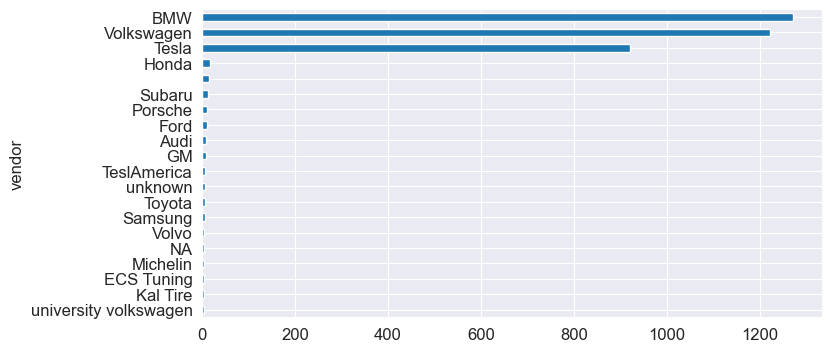

In [126]:
pd.set_option('display.max_rows', 200)

sent_df['vendor'].value_counts().head(20).plot(kind='barh').invert_yaxis()

In [127]:
from blueprints.exploration import wordcloud

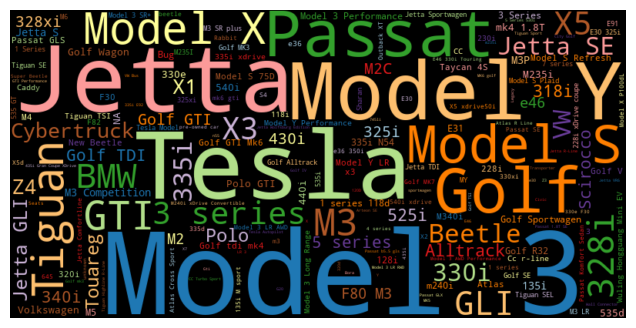

In [128]:
wordcloud(sent_df['model'].value_counts())

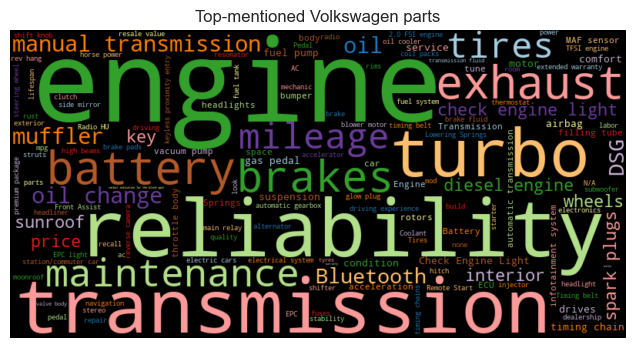

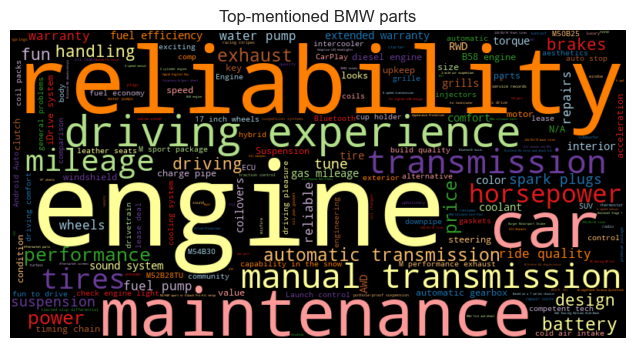

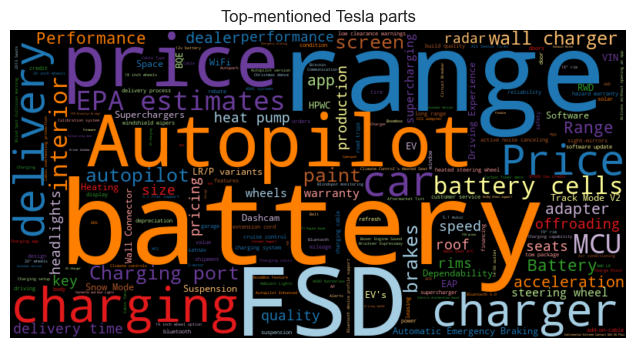

In [130]:
for vendor in ['Volkswagen', 'BMW', 'Tesla']:
    tmp_df = sent_df.query('vendor == @vendor')

    # tmp_df = tmp_df.query('model.str.contains("Golf")')
    part_counts = tmp_df.groupby('part').id.count()
    wordcloud(part_counts, title=f"Top-mentioned {vendor} parts")
    plt.show()

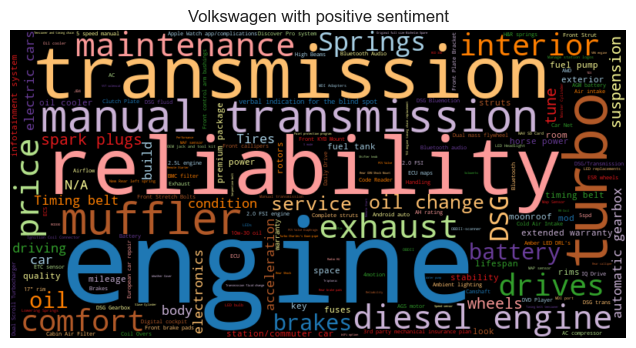

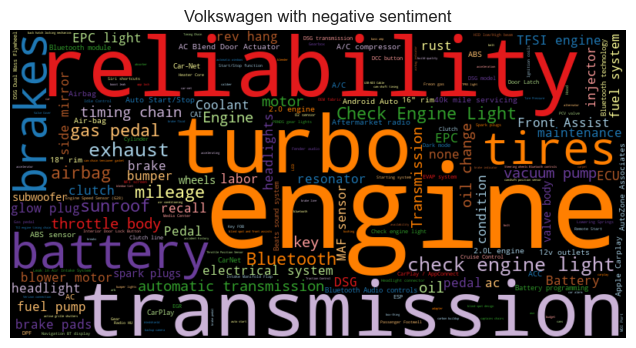

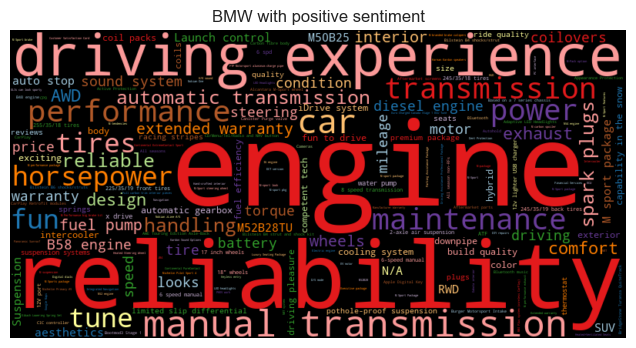

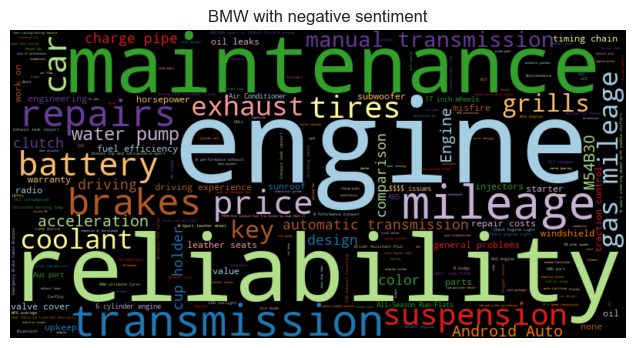

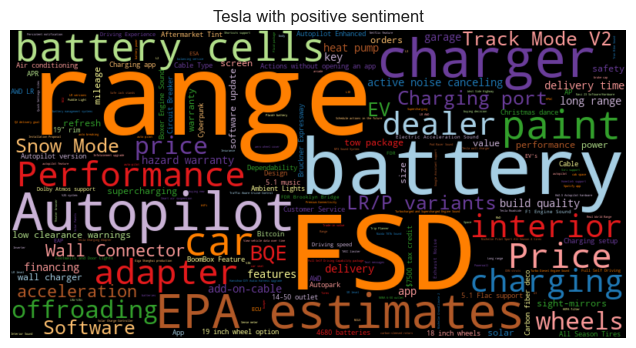

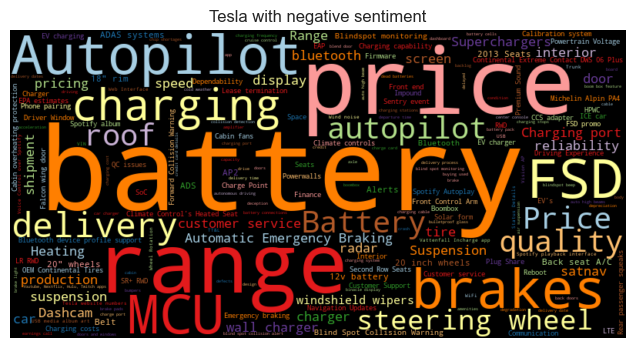

In [131]:
for vendor in ['Volkswagen', 'BMW', 'Tesla']:
    for sentiment in ['positive', 'negative']:

        tmp_df = sent_df.query('vendor == @vendor') \
                        .query('sentiment == @sentiment') 

        # tmp_df = tmp_df.query('model.str.contains("Golf")')
        part_counts = tmp_df.groupby('part').id.count()
        wordcloud(part_counts, title=f"{vendor} with {sentiment} sentiment")
        plt.show()

## Sentiment Analysis Using Huggingface Transformers

Links: 
  * [Transformers Library from Hugging Face](https://huggingface.co/transformers)
  * [Transformers Quick Tour](https://huggingface.co/transformers/quicktour.html)

### Load a Model for Sentiment Analysis

For a list of models see [Hugging Face Model Hub](https://huggingface.co/models).

Model download takes a moment ...

It's stored in `~/.cache/huggingface/transformers` (see [Huggingface documentation](https://huggingface.co/docs/datasets/installation.html#caching-datasets-and-metrics)).

In [ ]:
from transformers import pipeline

# classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')
classifier = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
classifier.model

This model was trained on product reviews in five languages. Predicts ratings from 1 to 5 stars.

In [ ]:
sents = [
  'We are very happy to show you the 🤗 Transformers library.',
  'The weather today is not really what I expected.'
]

classifier(sents)

### Aspect-based Sentiment Analysis

Check sentiment for the aspect "charging" in Tesla subreddit.

Look for token 'charge' in subreddit 'teslamotors' and exclude questions ('?').

In [ ]:
pd.set_option('max_colwidth', 3000)

senti_df = df[
    (df['lemmas'].str.len() < 400) &
    df['lemmas'].str.lower().str.contains('charge') &
    (~df['text'].str.contains('\?')) &
    (df['subreddit']=='teslamotors')][['text']].sample(20)
senti_df.reset_index(inplace=True)

Add sentiment prediction:

In [ ]:
senti_df.join(pd.DataFrame(classifier(list(senti_df['text'].str.lower()))))

## Question Answering

Training based on Stanford Question Answering Dataset (SQuAD 2.0).  

See
  * https://rajpurkar.github.io/SQuAD-explorer/explore/v2.0/dev/European_Union_law.html
  * [Huggingface documentation for QA](https://huggingface.co/transformers/usage.html#extractive-question-answering)

In [ ]:
from transformers import pipeline

qa_model = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the `run_squad.py`.
"""

question = "What is extractive question answering?"
answer = qa_model(question=question, context=context)
print("Q:", question)
print("A:", answer['answer'], f"(confidence: {answer['score']:.2f})\n")

question = "What is a good example of a question answering dataset?"
answer = qa_model(question=question, context=context)
print("Q:", question)
print("A:", answer['answer'], f"(confidence: {answer['score']:.2f})\n")

Examples from [Game of Thrones Wiki](https://gameofthrones.fandom.com/wiki):

In [ ]:
from transformers import pipeline

qa_model = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

context = """
Bran is the fourth child and second son of Lady Catelyn and Lord Ned
Stark. Ned is the head of House Stark, Lord Paramount of the North,
and Warden of the North to King Robert Baratheon. The North is one of
the constituent regions of the Seven Kingdoms and House Stark is one
of the Great Houses of the realm. House Stark rules the region from
their seat of Winterfell.

Winterfell is the capital of the Kingdom of the North and the seat and 
the ancestral home of the royal House Stark. It is a very large castle 
located at the center of the North, from where the head of House Stark 
rules over his or her people. """

question = "Who is Bran?"
answer = qa_model(question=question, context=context)
print("Q:", question)
print("A:", answer['answer'], f"(confidence: {answer['score']:.2f})\n")

question = "What is Winterfell?"
answer = qa_model(question=question, context=context)
print("Q:", question)
print("A:", answer['answer'], f"(confidence: {answer['score']:.2f})\n")

question = "Where is Winterfell located?"
answer = qa_model(question=question, context=context)
print("Q:", question)
print("A:", answer['answer'], f"(confidence: {answer['score']:.2f})\n")